# Equivalent Circuit Parameter Identification and Sensitivity Analysis

## Estimating resistance and capacitance values from HPPC data

This notebook demonstrates how to identify stationary parameters for a two RC branch Thevenin model. Sensitivity analysis is then performed using the SALib module [1].

[1] Iwanaga, T., Usher, W., & Herman, J. (2022). Toward SALib 2.0: Advancing the accessibility and interpretability of global sensitivity analyses. Socio-Environmental Systems Modelling, 4(1), 1–15. https://doi.org/10.18174/sesmo.18155

### Setting up the Environment

If you don't already have PyBOP installed, check out the [installation guide](https://pybop-docs.readthedocs.io/en/latest/installation.html) first.

We begin by upgrading some dependencies and importing the necessary libraries. Let's also fix the random seed to generate consistent output during development.

In [ ]:
%pip install --upgrade openpyxl pandas -q

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
from pybamm import Parameter
from SALib.analyze import morris as morris_analyze
from SALib.analyze import sobol
from SALib.sample import morris as morris_sample
from SALib.sample import sobol as sobol_sample

import pybop

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

np.random.seed(8)  # users can remove this line

/home/nicola/GitHub/PyBOP/.nox/notebooks-overwrite/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


## Setting up the model

First let's create the model with two RC elements. In this example, we use the default parameter value for the `"Open-circuit voltage [V]"` as provided by the original PyBaMM class.

In [ ]:
model = pybamm.equivalent_circuit.Thevenin(options={"number of rc elements": 2})
parameter_values = pybamm.ParameterValues("ECM_Example")
parameter_values.update(
    {
        "Cell capacity [A.h]": 3,
        "Nominal cell capacity [A.h]": 3,
        "Element-1 initial overpotential [V]": 0,
        "Element-2 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 0.1,
        "R2 [Ohm]": 0.001,
        "Tau1 [s]": 1.0,
        "Tau2 [s]": 100.0,
        "C1 [F]": Parameter("Tau1 [s]") / (Parameter("R1 [Ohm]") + np.finfo(float).eps),
        "C2 [F]": Parameter("Tau2 [s]") / (Parameter("R2 [Ohm]") + np.finfo(float).eps),
    },
    check_already_exists=False,
)

## Importing data

Next we select the data for parameter identification. In this example we use a single HPPC pulse from an open dataset [2].

[2] Kollmeyer, Phillip; Skells, Michael (2020), “Samsung INR21700 30T 3Ah Li-ion Battery Data”, Mendeley Data, V1. https://doi.org/10.17632/9xyvy2njj3.1

This dataset is imported and used to construct the `pybop.Dataset` class,

In [ ]:
file_loc = r"../../data/Samsung_INR21700/sample_hppc_pulse.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(),
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)

## Identifying the parameters

Next, we define the parameters for identification. In this example, we've constructed a two-branch Thevenin model, so we will select all five resistance and capacitance parameters for identification. The initial guess for each resistance parameter is generated from a random sample of the prior distributions. These are influenced by the `r_guess` parameter below.

In [ ]:
r_guess = 0.005
parameter_values.update(
    {
        "R0 [Ohm]": pybop.Parameter(
            pybop.Gaussian(r_guess, r_guess / 10, truncated_at=[1e-06, 0.1]),
        ),
        "R1 [Ohm]": pybop.Parameter(
            pybop.Gaussian(r_guess, r_guess / 10, truncated_at=[1e-06, 0.02]),
        ),
        "R2 [Ohm]": pybop.Parameter(
            pybop.Gaussian(r_guess, r_guess / 10, truncated_at=[1e-06, 0.02]),
        ),
        "Tau1 [s]": pybop.Parameter(
            pybop.Gaussian(0.004, 0.0004, truncated_at=[1e-03, 10]),
        ),
        "Tau2 [s]": pybop.Parameter(
            pybop.Gaussian(20, 2, truncated_at=[10, 100]),
        ),
    }
)

The `Problem` class provides us with a single class that holds the objects we need to evaluate our selected `SumSquaredError` cost function. We first construct the simulator with an initial OCV state selected from the first data point in the HPPC pulse.

In [ ]:
parameter_values.set_initial_state(f"{df['Voltage'].to_numpy()[0]} V")
simulator = pybop.pybamm.Simulator(
    model,
    parameter_values=parameter_values,
    protocol=dataset,
    solver=pybamm.CasadiSolver(mode="safe", dt_max=10, rtol=1e-4),
)
cost = pybop.SumSquaredError(dataset)
problem = pybop.Problem(simulator, cost)

Next, we construct the optimisation class with our algorithm of choice and run it. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value.

In [ ]:
options = pybop.PintsOptions(
    max_unchanged_iterations=20,
    max_iterations=100,
)
optim = pybop.XNES(problem, options=options)
result = optim.run()
print(result)

OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [6.25051951e-03 6.40955945e-03 5.12879299e-03 3.76339124e-03
 1.73598590e+01]
  Optimised parameters: [1.27079213e-04 1.21160511e-02 1.79240654e-02 2.08186861e-02
 2.05779533e+01]
  Best cost: 0.0005883208401995079
  Optimisation time: 58.60585069656372 seconds
  Number of iterations: 100
  Number of evaluations: 770
  Reason for stopping: Maximum number of iterations (100) reached.


## Plotting and visualisation

Next, we use PyBOP's plotting utilities to visualise the results of the optimisation. This provides us with a visual confirmation of the optimiser's converged parameter values in the time-domain output.

In [ ]:
pybop.plot.problem(problem, inputs=result.best_inputs, title="Optimised Comparison");

## Performing sensitivity analysis

We use the Sobol and Morris methods from SALib to perform sensitivity analysis on the two RC pair model. More information on the sensitivity analysis methods available from SALib can be found [here](https://salib.readthedocs.io/en/latest/).

In [ ]:
# Define the SALib problem dictionary for sensitivity analysis
salib_dict = {
    "names": problem.parameters.names,
    "bounds": problem.parameters.get_bounds_array(),
    "num_vars": len(problem.parameters),
}

Let's create a helper function to evaluate the samples in a loop, using the `pybop.Problem` to evaluate the cost for each set of input parameters.

In [ ]:
def evaluate_samples(param_values: np.ndarray):
    """
    param_values: np.ndarray shape (N, n_params)
    returns: np.ndarray Y shape (N,)
    """
    t0 = time.time()
    N = param_values.shape[0]
    cost_values = np.empty(N)
    # Loop over 1/10th of the array at a time
    n = 0
    for params in np.array_split(param_values, 10):
        n_i = len(params)
        cost_values[n : n + n_i] = problem.evaluate(params).values
        n += n_i
        print(
            f"Eval {n}/{N}, elapsed time={time.time() - t0:.1f} s, last cost={cost_values[n - 1]:.6g}"
        )
    return cost_values

## Sobol sensitivity analysis

Choose a base sample size N (use N=512 or higher for better estimates) and generate a set of samples.

In [ ]:
N = 128
param_values = sobol_sample.sample(salib_dict, N, calc_second_order=False)

print("Running model for Saltelli sample of size:", param_values.shape)
Y_saltelli = evaluate_samples(param_values)

Running model for Saltelli sample of size: (896, 5)


Eval 90/896, elapsed time=1.4 s, last cost=0.155896


Eval 180/896, elapsed time=2.7 s, last cost=2.91953


Eval 270/896, elapsed time=4.0 s, last cost=3.443


Eval 360/896, elapsed time=5.3 s, last cost=0.0400496


Eval 450/896, elapsed time=6.5 s, last cost=2.15141


Eval 540/896, elapsed time=7.9 s, last cost=6.34475


Eval 629/896, elapsed time=9.1 s, last cost=2.45682


Eval 718/896, elapsed time=10.7 s, last cost=3.48555


Eval 807/896, elapsed time=11.8 s, last cost=6.53673


Eval 896/896, elapsed time=13.1 s, last cost=3.19176


Use the samples to analyse the Sobol indices.

In [ ]:
Si = sobol.analyze(
    salib_dict, Y_saltelli, calc_second_order=False, print_to_console=True
)
print("Sobol S1:", Si["S1"])
print("Sobol ST:", Si["ST"])

                ST   ST_conf
R0 [Ohm]  0.991417  0.164807
R1 [Ohm]  0.018585  0.005463
R2 [Ohm]  0.001103  0.000744
Tau1 [s]  0.008247  0.003998
Tau2 [s]  0.001137  0.000547
                S1   S1_conf
R0 [Ohm]  0.972346  0.222216
R1 [Ohm]  0.014623  0.026848
R2 [Ohm] -0.000235  0.007942
Tau1 [s]  0.010430  0.023832
Tau2 [s] -0.002567  0.008329
Sobol S1: [ 9.72345726e-01  1.46225250e-02 -2.35067959e-04  1.04295189e-02
 -2.56709598e-03]
Sobol ST: [0.99141718 0.01858489 0.00110346 0.00824684 0.00113709]


Plot the results.

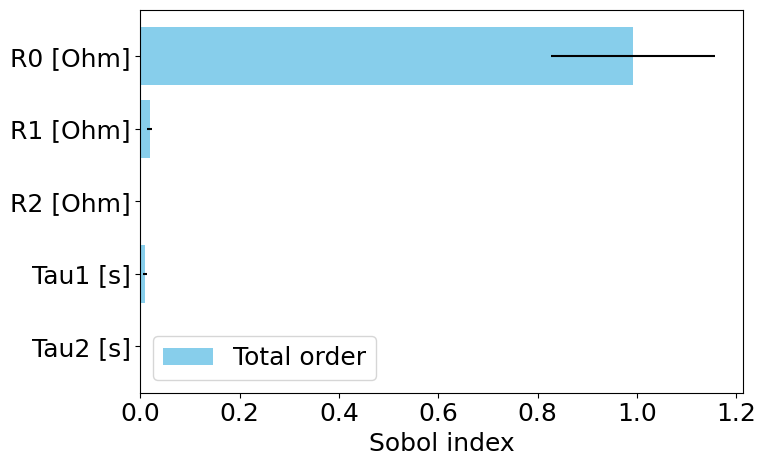

In [ ]:
plt.rcParams.update({"font.size": 18, "font.weight": "normal"})
plt.figure(figsize=(8, 5))
labels = salib_dict["names"]
plt.barh(labels, Si["ST"], xerr=Si["ST_conf"], color="skyblue", label="Total order")
# uncomment the below line to see first order indices
# plt.barh(labels, Si["S1"], xerr=Si["S1_conf"],  color="orange", alpha=0.7, label="First order")
plt.xlabel("Sobol index", fontweight="normal")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Morris sensitivity analysis

Generate a set of samples.

In [ ]:
# User settings
r = 10  # number of candidate trajectories (will generate r*(k+1) samples)
levels = 4  # number of grid levels for each parameter
optimal_k = 4  # number of optimal trajectories to select (< r)
fail_val = 1e5  # threshold to mark failed runs
seed = 123  # random seed for reproducibility

# Generate Morris samples
param_values_morris = morris_sample.sample(
    salib_dict,
    N=r,
    num_levels=levels,
    optimal_trajectories=optimal_k,
    local_optimization=False,
    seed=seed,
)
print("Morris sample generated:", param_values_morris.shape)

# Evaluate model for all samples
Y_morris = evaluate_samples(param_values_morris)
print("Model evaluations complete:", Y_morris.shape)
print(Y_morris)

Morris sample generated: (24, 5)


Eval 3/24, elapsed time=0.2 s, last cost=9.98395


Eval 6/24, elapsed time=0.4 s, last cost=1.30937


Eval 9/24, elapsed time=0.7 s, last cost=0.0330074


Eval 12/24, elapsed time=0.9 s, last cost=0.140275


Eval 14/24, elapsed time=1.1 s, last cost=6.45869


Eval 16/24, elapsed time=1.3 s, last cost=0.315565


Eval 18/24, elapsed time=1.4 s, last cost=0.322637


Eval 20/24, elapsed time=1.6 s, last cost=0.567131


Eval 22/24, elapsed time=1.7 s, last cost=6.64031


Eval 24/24, elapsed time=1.9 s, last cost=8.7264
Model evaluations complete: (24,)
[7.02927617 7.60795018 9.98394694 1.33636604 1.30936964 1.3093725
 3.18786692 3.90932627 0.03300742 0.03482044 0.14028371 0.14027547
 7.19636823 6.45868702 6.45864622 0.3155649  0.3226275  0.32263744
 0.56708676 0.56713068 7.60961218 6.64031222 8.87236197 8.72639956]


Reshape the samples into trajectories and identify failures. Then analyse the Morris indices.

In [ ]:
k = salib_dict["num_vars"]  # number of parameters
r_total = int(param_values_morris.shape[0] / (k + 1))

samples_reshaped = param_values_morris.reshape((r_total, k + 1, k))
Y_reshaped = Y_morris.reshape((r_total, k + 1))

traj_has_fail = np.any(Y_reshaped > fail_val, axis=1)
n_fail_traj = np.sum(traj_has_fail)
n_valid_traj = r_total - n_fail_traj

print(
    f"Total trajectories: {r_total}, Failed trajectories: {n_fail_traj}, Valid trajectories: {n_valid_traj}"
)

if n_valid_traj == 0:
    raise RuntimeError(
        "All trajectories failed — cannot compute Morris indices. "
        "Consider reducing penalty or tightening bounds."
    )

# Keep only valid trajectories
valid_idx = np.where(~traj_has_fail)[0]
samples_valid = samples_reshaped[valid_idx].reshape((n_valid_traj * (k + 1), k))
Y_valid = Y_reshaped[valid_idx].reshape((n_valid_traj * (k + 1),))

print("Valid samples shape:", samples_valid.shape, "Valid Y shape:", Y_valid.shape)

# Recompute Morris indices on valid trajectories
morris_res = morris_analyze.analyze(
    salib_dict, samples_valid, Y_valid, num_levels=levels, print_to_console=True
)

print("\nMorris mu* (clean):", morris_res["mu_star"])
print("Morris sigma (clean):", morris_res["sigma"])

Total trajectories: 4, Failed trajectories: 0, Valid trajectories: 4
Valid samples shape: (24, 5) Valid Y shape: (24,)
                mu   mu_star     sigma  mu_star_conf
R0 [Ohm]  9.641048  9.641048  2.987019      2.328316
R1 [Ohm]  1.965099  2.044197  1.799502      1.546974
R2 [Ohm]  0.066828  0.068188  0.103008      0.088456
Tau1 [s] -0.487570  0.487570  0.569701      0.520493
Tau2 [s] -0.363501  0.363507  0.726966      0.719571

Morris mu* (clean): [9.641048461758706 2.044196618906839 0.06818791206851062
 0.4875702106674279 0.36350694628871716]
Morris sigma (clean): [2.9870195  1.79950199 0.10300767 0.56970091 0.72696612]


Plot the results of Morris's method.

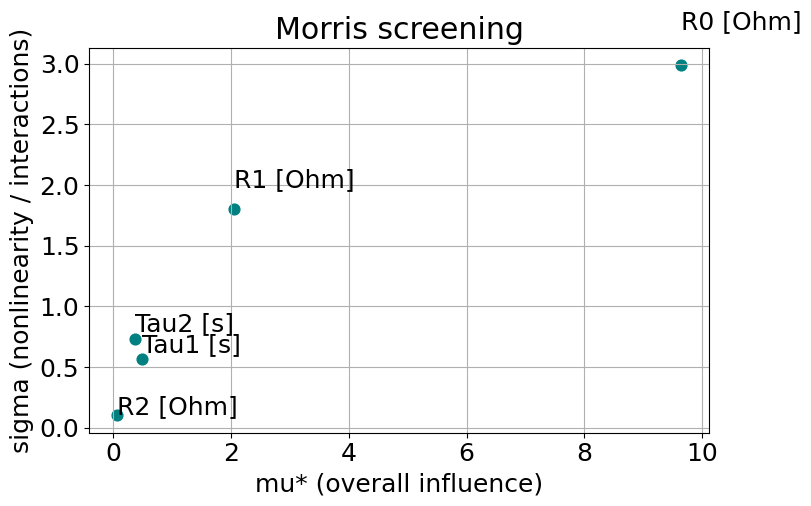

In [ ]:
labels = salib_dict["names"]
plt.figure(figsize=(8, 5))
plt.scatter(morris_res["mu_star"], morris_res["sigma"], s=60, color="teal")
for i, txt in enumerate(labels):
    plt.text(morris_res["mu_star"][i] * 1, morris_res["sigma"][i] * 1.1, txt)
plt.xlabel("mu* (overall influence)")
plt.ylabel("sigma (nonlinearity / interactions)")
plt.title("Morris screening")
plt.grid(True)
plt.show()

## Concluding thoughts

This notebook illustrates how to extract EC parameters from a HPPC pulse using PyBOP. A sensitivity analysis of the model is performed using the Sobol and Morris methods from the SALib module. Other methods from SALib can also be used. More information can be found [here](https://salib.readthedocs.io/en/latest/).